In [1]:
import pandas as pd
import sys, os

sys.path.append("../lib")
import gene_enrichment_utils as utils

In [ ]:
# Define filepaths

BASE_DATAPATH = "../data"
FIGURES_PATH = "../figures/"
RESULTS_PATH = "../results/"
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

targets_3utr_top10_path = os.path.join(BASE_DATAPATH, "cd4_3utr_bs_top_targets.txt")
all_rnaseq_genes_path = os.path.join(BASE_DATAPATH, "geneset_all_rnaseq_genes_t0.txt")

In [3]:
custom_genes_path = os.path.join(BASE_DATAPATH, "turner_paper_gsea_geneset.csv")

custom_genes_df = pd.read_csv(custom_genes_path, sep=";", header=0)
# Drop first row and first column
custom_genes_df = custom_genes_df.drop(custom_genes_df.index[0])
custom_genes_df = custom_genes_df.drop(custom_genes_df.columns[0], axis=1)
custom_genes_df.head()

,Cell cycle,DNA replication,DNA repair,RNA polymerase,RNA degradation,Spliceosome,Ribosome biogenesis in eukaryotes,Aminoacyl tRNA biosynthesis,Proteasome,Apoptosis,...,IL-2 receptor signalling,TCR signalling,T cell differentiation,Treg signature,Increased in IL-2,Decreased in IL-2,Increased in IL-7,Decreased in IL-7,Increased in IFNg,Decreased in IFNg
1,Ccnd1,Ssbp1,Polr2h,Polr2b,Dcps,Ddx46,Csnk2b,mt-Ta,Psmd3,Casp3,...,Il2ra,Abl1,Bcl11a,Il2ra,Vim,Smc4,Ltb,Eef2,Efna5,Pfn2
2,Ccnd2,Rnaseh1,Polr2a,Polr2a,Exosc1,Ddx39b,Csnk2a1,mt-Tr,Psmd12,Casp9,...,Il2rb,Abl2,Bcl2,March3,Il2ra,Cd5,Gpr83,Ets1,Pros1,Spin2c
3,Ccnd3,Rpa1,Polr2g,Polr2c,Exosc2,Dhx16,Csnk2a2,mt-Tn,Psmd11,Dffa,...,Il2rg,Akt1,Bcl2a1d,1110032F04Rik,Gpr83,Kcnn4,Tnfrsf4,Lcp1,Il4i1,Kit
4,Cdk4,Pcna,Polr2e,Polr2j,Exosc3,Dhx38,Nol6,mt-Td,Psmd6,Casp7,...,Jak1,Akt2,Cacnb4,2010111I01Rik,Lrrc32,Klf13,Tnfrsf18,Msn,Il24,Nacc2
5,Cdk6,Dna2,Polr2f,Polr2d,Exosc8,Cdc40,Rrp7a,mt-Tc,Psmd7,Cflar,...,Jak3,Akt3,Cd4,2510009E07Rik,Mat2a,Sesn1,Cish,Uba1,Lad1,Tnfaip8l2


In [4]:
# Transform to dict using df.columns as keys and df.values as values
custom_genes_dict = custom_genes_df.to_dict('list')
# Remove all 'nan' from the lists
for key in custom_genes_dict:
    custom_genes_dict[key] = [x for x in custom_genes_dict[key] if str(x) != 'nan']

In [ ]:
# count number of uniques genes
all_genes = []
for key in custom_genes_dict:
    all_genes.extend(custom_genes_dict[key])
all_genes = list(set(all_genes))
print(f"Total unique genes: {len(all_genes)}")

Total unique genes: 3930


In [6]:
targets_3utr_top10 = utils.read_txt_file(targets_3utr_top10_path)
all_rnaseq_genes = utils.read_txt_file(all_rnaseq_genes_path)
all_rnaseq_genes[:5]

['ENSMUSG00000042807',
 'ENSMUSG00000003206',
 'ENSMUSG00000029837',
 'ENSMUSG00000029836',
 'ENSMUSG00000029830']

In [7]:
# Use mygene to retrieve gene annotations, including entrez ids
import mygene
mg = mygene.MyGeneInfo()

# We retrieve the entrez gene ids for the all the rnaseq genes
# https://docs.mygene.info/projects/mygene-py/en/latest/#mygene.MyGeneInfo.querymany
gene_query = mg.querymany(
    set(all_rnaseq_genes), 
    scopes='ensemblgene', 
    fields=['entrezgene', 'symbol'], 
    species='mouse') # 421 input query terms found no hit

gene_query[:1]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-16146...done.
Finished.
1 input query terms found dup hits:
	[('ENSMUSG00000072694', 2)]
421 input query terms found no hit:
	['ENSMUSG00000087324', 'ENSMUSG00000019769', 'ENSMUSG00000073617', 'ENSMUSG00000088789', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'ENSMUSG00000034731',
  '_id': '380921',
  '_score': 26.703125,
  'entrezgene': '380921',
  'symbol': 'Dgkh'}]

In [8]:
# Build a dictionary to map ensembl gene ids to entrez gene ids
gene_map = {} # key = ensembl gene id, value = entrez gene id
gene_symbol_map = {} # key = ensembl gene id, value = gene symbol
for item in gene_query:
    if 'entrezgene' in item:
        q, ent_gene = item['query'], int(item['entrezgene']) # 'query' is the ensembl gene id, 'entrezgene' needs to be casted to int otherwise goatools won't work and won't give errors!!
        gene_map[q] = ent_gene
        gene_symbol_map[q] = item['symbol'] # This maps query ensemble gene ids to gene symbols

targets_3utr_top10_symbols = utils.convert_ensembl_id(targets_3utr_top10, gene_symbol_map)
all_rnaseq_genes_symbols = utils.convert_ensembl_id(all_rnaseq_genes, gene_symbol_map)

In [9]:
targets_3utr_top10_symbols[:5]

['Lfng', 'Tfdp1', 'Socs1', 'Nfkbid', 'Slc25a3']

In [10]:
ora_results_3utr_top10 = utils.perform_ora(targets_3utr_top10_symbols, 
                                custom_genes_dict, 
                                all_rnaseq_genes_symbols)
ora_results_3utr_top10_path = os.path.join(RESULTS_PATH, 
                                "ora_results_targets_3utr_top10_custom_geneset.csv")
ora_results_3utr_top10.to_csv(ora_results_3utr_top10_path, sep="\t", index=False)

print(len(ora_results_3utr_top10))
ora_results_3utr_top10.head(n=20)

13


,term,study_count,background_count,p_value,FDR,study_genes
34,T cell differentiation,19,218,1.045268e-11,4.390127e-10,"[Ptprc, B2m, Rc3h1, Zbtb1, Zap70, Tcf7, Adam17..."
36,Increased in IL-2,10,169,3.107934e-05,6.526661e-04,"[Ppan, Mat2a, Tfrc, Irf4, Tnf, Nfkbiz, Map3k8,..."
31,TGF beta signaling pathway,5,58,5.872441e-04,7.941852e-03,"[Tfdp1, Id3, Tnf, Rhoa, Id2]"
38,Increased in IL-7,7,132,9.454585e-04,7.941852e-03,"[Tnfrsf4, Ppan, Tnf, Socs2, Pim2, Socs1, Id2]"
33,TCR signalling,9,211,8.816778e-04,7.941852e-03,"[Ptprc, Cdc42, Ets1, Itk, Irf4, Map3k8, Zap70,..."
26,Chemokine signaling pathway,7,140,1.332474e-03,7.994841e-03,"[Cdc42, Rap1b, Adcy7, Stat1, Itk, Rhoa, Pik3ca]"
13,Unfolded protein response,6,100,1.159520e-03,7.994841e-03,"[Calr, Eif2ak3, Dkc1, Herpud1, Ddit4, Eif4a1]"
37,Decreased in IL-2,6,118,2.696181e-03,1.301822e-02,"[Klf13, Bcl9l, Id3, Axin2, Ddit4, Tcf7]"
12,Leukocyte transendothelial migration,5,82,2.789618e-03,1.301822e-02,"[Cdc42, Rap1b, Itk, Rhoa, Pik3ca]"
22,mTOR signaling pathway,6,126,3.732503e-03,1.567651e-02,"[Eif4b, Tnf, Rhoa, Sgk1, Ddit4, Pik3ca]"


In [12]:
# NOTE: We post-filter terms that do not concern us
terms_to_remove = ["IL-2", "IL-7"]
# remove all rows where term contains any of the terms in terms_to_remove
for term in terms_to_remove:
    ora_results_3utr_top10 = ora_results_3utr_top10[~ora_results_3utr_top10['term'].str.contains(term)]
ora_results_3utr_top10 = ora_results_3utr_top10.reset_index(drop=True)

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

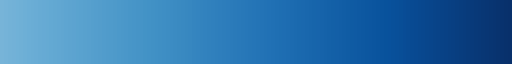

In [54]:
import numpy as np
import matplotlib
cm_blues = matplotlib.cm.Blues(np.linspace(0,1,256)) # this makes a gradient
cm_blues = matplotlib.colors.ListedColormap(cm_blues[120:,:-1])
# cmap = matplotlib.colors.ListedColormap(cmap)
cm_blues

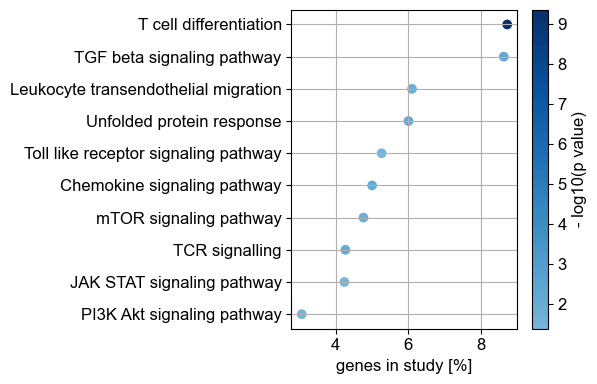

In [ ]:
utils.plot_enrichment_scatter(ora_results_3utr_top10, 
                        x_column='study_count', 
                        y_column='term', 
                        pvalue_column='FDR', 
                        figsize=(6, 4), 
                        top_n=None, 
                        # cmap="winter",
                        cmap=cm_blues,
                        outpath=os.path.join(FIGURES_PATH, "ora_results_targets_3utr_top10_custom_geneset.pdf"))